### Importing Dataset & required Libraries

In [253]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing as scale
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score as AUC

In [254]:
df = pd.read_csv('Maintenance.csv')

### EDA

In [255]:
df.shape

(10000, 14)

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [257]:
#null values
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [258]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [259]:
#duplicates
dups = df.duplicated()
print('Number of duplicate rows: %d' % dups.sum())

Number of duplicate rows: 0


Text(0.5, 1.05, 'Pearson correlation of Features')

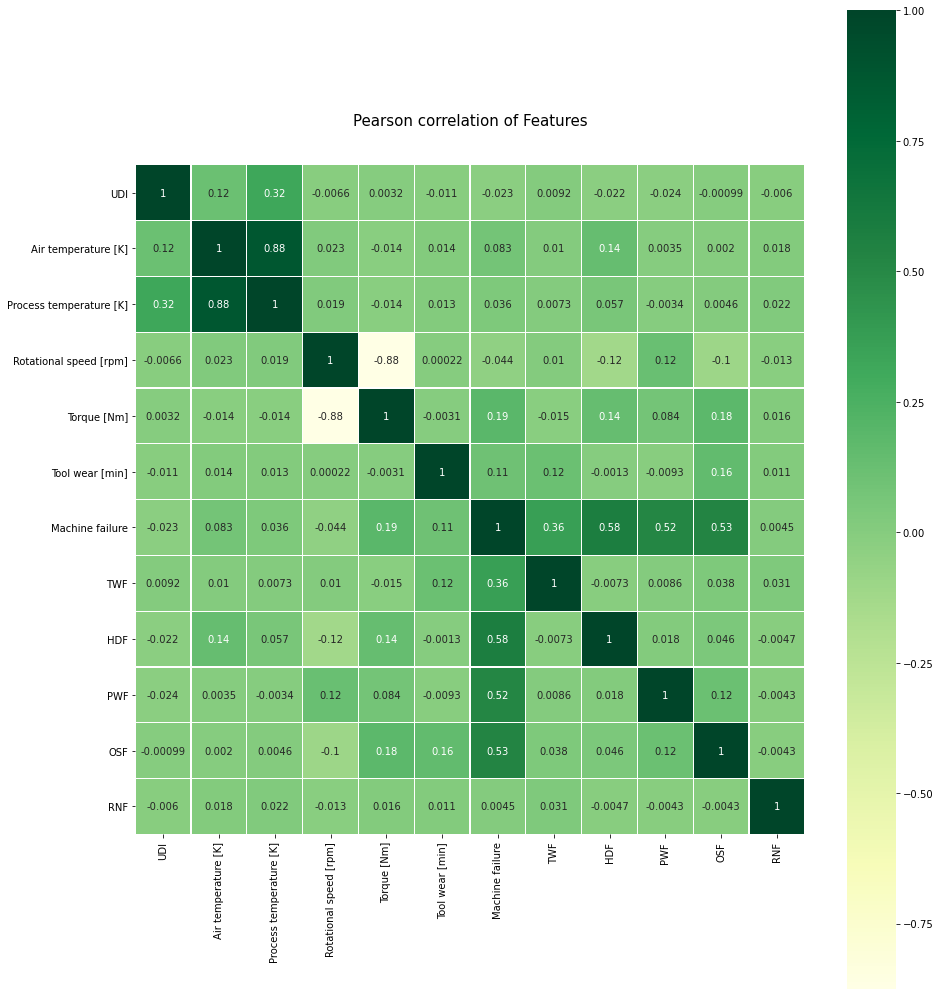

In [260]:
#Heatmap for Corelation
corr = df.corr()

f, ax = plt.subplots(figsize=(15,18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

In [261]:
#machine failure counts with subgroups
df[['Machine failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF']].apply(pd.value_counts)

,Machine failure,TWF,HDF,PWF,OSF,RNF
0,9661,9954,9885,9905,9902,9981
1,339,46,115,95,98,19


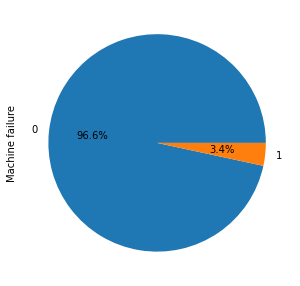

In [262]:
#pie for total machine failures
df['Machine failure'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%')
plt.show()

In [263]:
#pie for all the subgroups failure contribution
Pie={'TWF': df.TWF.sum(), 'HDF':df.HDF.sum(), 'PWF':df.PWF.sum(), 'OSF': df.OSF.sum(), 'RNF': df.RNF.sum()}

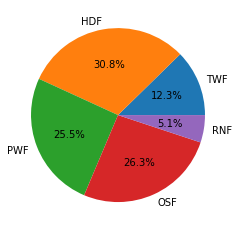

In [264]:
plt.pie(Pie.values(),labels=Pie.keys(),autopct='%1.1f%%');

In [265]:
#types of machine quality
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

<AxesSubplot:>

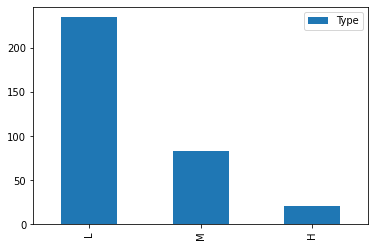

In [266]:
#failure with respect to Type
df[df['Machine failure'] == 1][[ 'Type']].apply(pd.value_counts).plot(kind='bar')

+ Lowest Quality type has the most failures
+ Followed by Medium and High

### Feature Engineering - Label Encoder

In [267]:
#label Encoding type column
from sklearn.preprocessing import LabelEncoder
label= LabelEncoder()
df['Type']= label.fit_transform(df['Type'])

### Detection of outliers - (Isolation Forest) 

In [268]:
from sklearn.ensemble import IsolationForest

In [269]:
outlier_model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2))

outlier_model.fit(df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']])


IsolationForest(contamination=0.2)

In [270]:
#predicting anomalies
df['scores'] = outlier_model.decision_function(df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']])

df['anomaly_score'] = outlier_model.predict(df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']])

df[df['anomaly_score']==-1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,scores,anomaly_score
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,-0.000861,-1
14,15,L47194,1,298.6,309.2,2035,19.6,40,0,0,0,0,0,0,-0.062314,-1
50,51,L47230,1,298.9,309.1,2861,4.6,143,1,0,0,1,0,0,-0.150257,-1
69,70,L47249,1,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,-0.024193,-1
70,71,M14930,2,298.9,309.0,1924,22.6,193,0,0,0,0,0,0,-0.020572,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9926,9927,M24786,2,298.5,308.6,1897,20.2,50,0,0,0,0,0,0,-0.027313,-1
9939,9940,H39353,0,298.3,308.1,2636,12.8,84,0,0,0,0,0,0,-0.164540,-1
9974,9975,L57154,1,298.6,308.2,1361,68.2,172,1,0,0,1,1,0,-0.040465,-1
9988,9989,L57168,1,298.9,308.6,1771,24.1,213,0,0,0,0,0,0,-0.028472,-1


### Dealing with outliers - Undersampling of majority class outliers 

In [271]:
count = df[df['anomaly_score']==-1]

In [272]:
count[count['Machine failure']==1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,scores,anomaly_score
50,51,L47230,1,298.9,309.1,2861,4.6,143,1,0,0,1,0,0,-0.150257,-1
69,70,L47249,1,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,-0.024193,-1
160,161,L47340,1,298.4,308.2,1282,60.7,216,1,0,0,0,1,0,-0.066450,-1
168,169,L47348,1,298.4,308.3,1433,62.3,20,1,0,0,1,0,0,-0.026002,-1
194,195,M15054,2,298.2,308.5,2678,10.7,86,1,0,0,1,0,0,-0.164018,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,1,298.6,309.8,2271,16.2,218,1,1,0,0,0,0,-0.124791,-1
9764,9765,L56944,1,298.5,309.5,1294,66.7,12,1,0,0,1,0,0,-0.071870,-1
9822,9823,L57002,1,298.5,309.4,1360,60.9,187,1,0,0,0,1,0,-0.009006,-1
9830,9831,L57010,1,298.3,309.3,1337,56.1,206,1,0,0,0,1,0,-0.016256,-1


In [273]:
df[(df['Machine failure']==0) & (df['anomaly_score']==-1)].index

Int64Index([   2,   14,   70,  101,  110,  126,  139,  155,  165,  169,
            ...
            9878, 9882, 9886, 9893, 9912, 9919, 9926, 9939, 9988, 9991],
           dtype='int64', length=1781)

In [274]:
#dropping outliers where machine faliure is zero
droped_df= df.drop(df[(df['Machine failure']==0) & (df['anomaly_score']==-1)].index)

In [275]:
droped_df['Machine failure'].value_counts()

0    7880
1     339
Name: Machine failure, dtype: int64

### Balancing the dataset -  Oversampling using SMOTE

In [276]:
droped_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,scores,anomaly_score
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0.014245,1
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0.012442,1
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0.035828,1
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0.032426,1
5,6,M14865,2,298.1,308.6,1425,41.9,11,0,0,0,0,0,0,0.037558,1


In [277]:
from imblearn.over_sampling import SMOTE

In [278]:
X=droped_df.iloc[:,[2,3,4,5,6,7,9,10,11,12,13]]
y=droped_df.iloc[:,8]
print(X.shape,y.shape)

(8219, 11) (8219,)


In [279]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)

x_smote, y_smote = smote.fit_resample(X, y)

In [280]:
from collections import Counter

In [281]:
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 7880, 1: 339})
Resample dataset shape Counter({0: 7880, 1: 7880})


In [282]:
processed_df = x_smote
processed_df['Machine failure'] = y_smote
processed_df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
3,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
4,2,298.1,308.6,1425,41.9,11,0,0,0,0,0,0


### Checking for originality of data

##### 1. Distribution of Type  

In [283]:
o_type = df['Type'].value_counts(normalize=True)
p_type = processed_df['Type'].value_counts(normalize=True)

print('The distribution of "Type" in original data:\n',o_type.mul(100).round(1).astype(str)+' %')
print('\nThe distribution of "Type" in processed data:\n',p_type.mul(100).round(1).astype(str)+' %')

The distribution of "Type" in original data:
 1    60.0 %
2    30.0 %
0    10.0 %
Name: Type, dtype: object

The distribution of "Type" in processed data:
 1    70.6 %
2    18.8 %
0    10.6 %
Name: Type, dtype: object


<AxesSubplot:title={'center':'Processed Data'}>

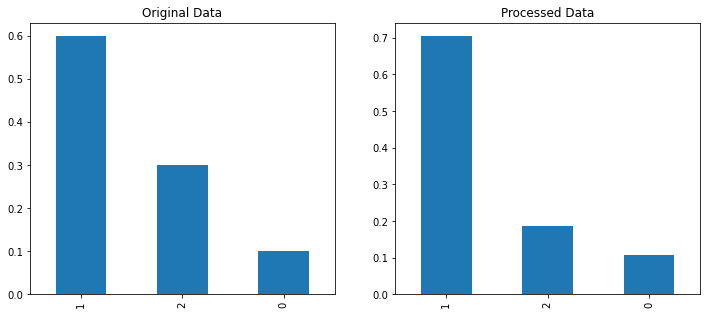

In [284]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original Data')
o_type.plot(kind='bar')
plt.subplot(1,2,2)
plt.title('Processed Data')
p_type.plot(kind='bar')

##### 2. Comparison on Mean and Standard Deviation 

In [285]:
mean_std = pd.DataFrame()

mean_std['Original Mean'] = df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']].mean()
mean_std['Processed Mean'] = processed_df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']].mean()
mean_std['Original SD'] = df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']].std()
mean_std['Processed SD'] = processed_df[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]',
           'Torque [Nm]','Tool wear [min]']].std()

mean_std

,Original Mean,Processed Mean,Original SD,Processed SD
Air temperature [K],300.00493,300.382584,2.000259,1.817434
Process temperature [K],310.00556,310.108000,1.483734,1.196008
Rotational speed [rpm],1538.77610,1505.183122,179.284096,282.058889
Torque [Nm],39.98691,45.191974,9.968934,13.404266
Tool wear [min],107.95100,126.024492,63.654147,68.722324


##### 3. Distribution of failure types 

In [286]:
o_pie={'TWF': df.TWF.sum(), 'HDF':df.HDF.sum(), 'PWF':df.PWF.sum(), 'OSF': df.OSF.sum(), 'RNF': df.RNF.sum()}
p_pie={'TWF': processed_df.TWF.sum(), 'HDF':processed_df.HDF.sum(), 'PWF':processed_df.PWF.sum(), 'OSF': processed_df.OSF.sum(), 'RNF': processed_df.RNF.sum()}

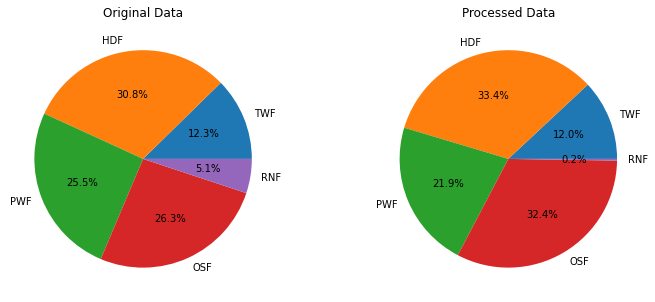

In [287]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original Data')
plt.pie(o_pie.values(),labels=o_pie.keys(),autopct='%1.1f%%');
plt.subplot(1,2,2)
plt.title('Processed Data')
plt.pie(p_pie.values(),labels=p_pie.keys(),autopct='%1.1f%%');

In [288]:
processed_df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
3,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
4,2,298.1,308.6,1425,41.9,11,0,0,0,0,0,0


In [289]:
#renaming the column names
processed_df.rename(columns={'Air temperature [K]': 'Air_temp',
                             'Process temperature [K]': 'Process_temp',
                            'Rotational speed [rpm]': 'RPM',
                            'Torque [Nm]': 'Torque',
                            'Tool wear [min]': 'Tool_wear',
                            'Machine failure': 'Machine_failure',}, inplace=True)

### Model Building

##### Train Test split 

In [290]:
# Splitting predictor and target variables
X=processed_df.iloc[:,:6]
y=processed_df.iloc[:,11]

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### 1. Logistic Regression 

In [292]:
LR_model=LogisticRegression()
LR_model = LR_model.fit(X_train, y_train)
LR_model_cv = LR_model.fit(X, y)

In [293]:
#prediction 
LR_train_pred = LR_model.predict(X_train)
LR_test_pred = LR_model.predict(X_test)
LR_full_pred = LR_model.predict(X)

#### 2. Decision Tree Classifier

In [294]:
#decision tree classifier
DT = DecisionTreeClassifier(random_state=12)
model_dt = DT.fit(X_train,y_train)
model_dt_cv = DT.fit(X,y)

In [295]:
#prediction 
DT_train_pred = model_dt.predict(X_train)
DT_test_pred = model_dt.predict(X_test)
DT_full_pred = model_dt.predict(X)

#### 3. Random Forest 

In [296]:
#rf = RandomForestClassifier(max_depth = 2,random_state=1)
rf = RandomForestClassifier(n_estimators=25, min_samples_split=25, \
                            max_depth=5,random_state=72)
model_rf = rf.fit(X_train,y_train)
model_rf_cv = rf.fit(X,y)

In [297]:
#prediction 
RF_train_pred = model_rf.predict(X_train)
RF_test_pred = model_rf.predict(X_test)
RF_full_pred = model_rf.predict(X)

#### 4. Gaussian Naive Bayes

In [298]:
gnb = GaussianNB()
modelgnb = gnb.fit(X_train,y_train)
modelgnb_cv = gnb.fit(X,y)

In [299]:
#prediction 
GNB_train_pred = modelgnb.predict(X_train)
GNB_test_pred = modelgnb.predict(X_test)
GNB_full_pred = modelgnb.predict(X)

#### 5. SVM

modelsvc = SVC(kernel='linear')
modelsvc = modelsvc.fit(X_train,y_train)
modelsvc_cv = modelsvc.fit(X,y)

#prediction 
SVC_train_pred = modelsvc.predict(X_train)
SVC_test_pred = modelsvc.predict(X_test)
SVC_full_pred = modelsvc.predict(X)

#### 6. 2nd Method Random Forest

In [300]:
classifier_R = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_R = classifier_R.fit(X_train, y_train)
classifier_R_cv = classifier_R.fit(X, y)

In [301]:
#prediction 
RF2_train_pred = classifier_R.predict(X_train)
RF2_test_pred = classifier_R.predict(X_test)
RF2_full_pred = classifier_R.predict(X)

#### 7. ANN

import keras
from keras.models import Sequential
from keras.layers import Dense

print(X_train.shape, y_test.shape)

classifier_A = Sequential()

classifier_A.add(Dense(8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
classifier_A.add(Dense(4, kernel_initializer = 'uniform', activation = 'relu'))
classifier_A.add(Dense(1,kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier_A.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier_A.summary()

Model_A = classifier_A.fit(X_train, y_train, batch_size = 1000, epochs = 100, shuffle = False)

#prediction 
ANN_train_pred = classifier_A.predict(X_train)
ANN_train_pred = (ANN_train_pred > 0.5)
ANN_test_pred = classifier_A.predict(X_test)
ANN_test_pred = (ANN_test_pred > 0.5)
ANN_full_pred = classifier_A.predict(X)
ANN_full_pred = (ANN_full_pred > 0.5)

Classifier_A_cv= Sequential()
Classifier_A_cv.add(Dense(8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
Classifier_A_cv.add(Dense(4, kernel_initializer = 'uniform', activation = 'relu'))
Classifier_A_cv.add(Dense(1,kernel_initializer = 'uniform', activation = 'sigmoid'))

Classifier_A_cv.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
Classifier_A_cv.summary()

classifier_A_cv = Classifier_A_cv.fit(X, y, batch_size = 1000, epochs = 100, shuffle = False)

#### 8. XGB Boost

In [302]:
params={
 'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 'max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [303]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [304]:
classifier_X=xgboost.XGBClassifier()

In [305]:
random_search=RandomizedSearchCV(classifier_X, param_distributions=params, n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [306]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [307]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [308]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [309]:
classifier_X=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [310]:
classifier_X = classifier_X.fit(X_train,y_train)
classifier_X_cv = classifier_X.fit(X,y)

[17:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [311]:
#prediction 
XGB_train_pred = classifier_X.predict(X_train)
XGB_test_pred = classifier_X.predict(X_test)
XGB_full_pred = classifier_X.predict(X)

### Model Evaluation

In [312]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#### 1. Logistic Regression 

In [313]:
#train_test evaluation
LR_train_score = accuracy_score(y_train,LR_train_pred)
LR_test_score = accuracy_score(y_test,LR_test_pred)
LR_full_score = accuracy_score(y,LR_full_pred)

print(LR_test_score)

0.8407360406091371


In [314]:
# cross validation
LR_cv=cross_val_score(LR_model_cv,X,y,cv=10)
LR_cv = LR_cv.mean()

#### 2. Decision Tree Classifier

In [315]:
DT_train_score = accuracy_score(y_train,DT_train_pred)
DT_test_score = accuracy_score(y_test,DT_test_pred)
DT_full_score = accuracy_score(y,DT_full_pred)

print(DT_test_score)

1.0


In [316]:
# cross validation
DT_cv=cross_val_score(model_dt_cv,X,y,cv=10)
DT_cv = DT_cv.mean()

#### 3. Random Forest 

In [317]:
RF_train_score = accuracy_score(y_train,RF_train_pred)
RF_test_score = accuracy_score(y_test,RF_test_pred)
RF_full_score = accuracy_score(y,RF_full_pred)

print(RF_test_score)

0.9511421319796954


In [318]:
# cross validation
RF_cv=cross_val_score(model_dt_cv,X,y,cv=10)
RF_cv = RF_cv.mean()

#### 4. Gaussian Naive Bayes 

In [319]:
GNB_train_score = accuracy_score(y_train,GNB_train_pred)
GNB_test_score = accuracy_score(y_test,GNB_test_pred)
GNB_full_score = accuracy_score(y,GNB_full_pred)

print(GNB_test_score)

0.8692893401015228


In [320]:
# cross validation
GNB_cv=cross_val_score(modelgnb_cv,X,y,cv=10)
GNB_cv = GNB_cv.mean()

#### 5. SVM 

SVC_train_score = accuracy_score(y_train,SVC_train_pred)
SVC_test_score = accuracy_score(y_test,SVC_test_pred)
SVC_full_score = accuracy_score(y,SVC_full_pred)

print(SVC_test_score)

# cross validation
SVC_cv=cross_val_score(modelsvc_cv,X,y,cv=10)
SVC_cv = SVC_cv.mean()

#### 6. Random Forest 2 

In [322]:
RF2_train_score = accuracy_score(y_train,RF2_train_pred)
RF2_test_score = accuracy_score(y_test,RF2_test_pred)
RF2_full_score = accuracy_score(y,RF2_full_pred)

print(RF2_test_score)

0.9996827411167513


In [323]:
# cross validation
RF2_cv=cross_val_score(classifier_R_cv,X,y,cv=10)
RF2_cv = RF2_cv.mean()

#### 7. ANN 

ANN_train_score = accuracy_score(y_train,ANN_train_pred)
ANN_test_score = accuracy_score(y_test,ANN_test_pred)
ANN_full_score = accuracy_score(y,ANN_full_pred)

print(ANN_test_score)

# cross validation
ANN_cv=cross_val_score(classifier_A_cv,X,y,cv=10)
ANN_cv = ANN_cv.mean()

#### 8. XGBoost 

In [324]:
XGB_train_score = accuracy_score(y_train,XGB_train_pred)
XGB_test_score = accuracy_score(y_test,XGB_test_pred)
XGB_full_score = accuracy_score(y,XGB_full_pred)

print(XGB_test_score)

1.0


In [325]:
# cross validation
XGB_cv=cross_val_score(classifier_X_cv,X,y,cv=10)
XGB_cv = XGB_cv.mean()

[17:08:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Comparison in DataFrame 

In [329]:
Evaluation = pd.DataFrame({'Models': ['Logistic Regression','Decision Tree','Random Forest','Gaussian NB',
                                      #'SVM',
                                      'Random Forest 2',#'ANN',
                                      'XGBoost'],
                     'Train Score': [LR_train_score,DT_train_score,RF_train_score,GNB_train_score,
                                     #SVC_train_score,
                                     RF2_train_score,#ANN_train_score,
                                     XGB_train_score],
                     'Test Score': [LR_test_score,DT_test_score,RF_test_score,GNB_test_score,
                                    #SVC_test_score,
                                    RF2_test_score,#ANN_test_score,
                                    XGB_test_score],
                     'Full Data Score': [LR_full_score,DT_full_score,RF_full_score,GNB_full_score,
                                         #SVC_full_score,
                                         RF2_full_score,#ANN_full_score,
                                         XGB_full_score],
})

In [330]:

Evaluation

,Models,Train Score,Test Score,Full Data Score
0,Logistic Regression,0.835977,0.840736,0.836929
1,Decision Tree,1.000000,1.000000,1.000000
2,Random Forest,0.952490,0.951142,0.952221
3,Gaussian NB,0.866434,0.869289,0.867005
4,Random Forest 2,0.999286,0.999683,0.999365
5,XGBoost,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Accuracy of models')

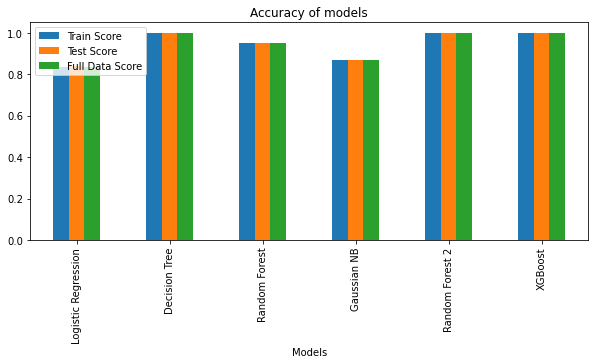

In [331]:
Evaluation.plot(x='Models', kind='bar', stacked=False, figsize=(10,4))
plt.title('Accuracy of models')

In [332]:
Evaluation.to_excel('Evaluation.xlsx')

In [334]:
cross_val = pd.DataFrame({'Models': ['Logistic Regression','Decision Tree','Random Forest','Gaussian NB',
                                      #'SVM',
                                      'Random Forest 2',#'ANN',
                                     'XGBoost'],
                         'Cross Validation': [LR_cv,DT_cv,RF_cv,GNB_cv,
                                     #SVC_cv,
                                     RF2_cv,#ANN_cv,
                                              XGB_cv]})

Text(0.5, 1.0, 'Accuracy of models')

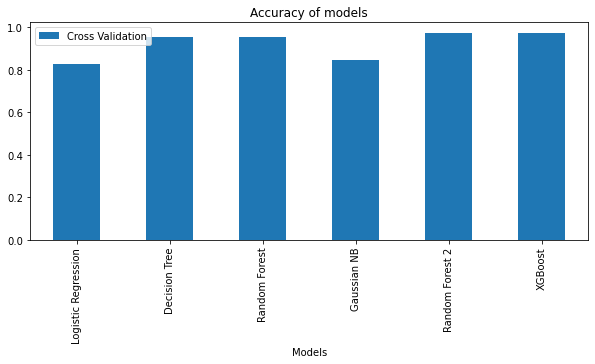

In [335]:
cross_val.plot(x='Models', kind='bar', figsize=(10,4))
plt.title('Accuracy of models')